In [1]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact #, interactive, fixed, interact_manual
from matplotlib.colors import ListedColormap

In [2]:
# Re-define the generate_rule_function for completeness
def generate_rule_function(wolfram_code):
    """Generate a rule function for the given Wolfram code."""
    binary_representation = format(wolfram_code, '08b')[::-1]
    
    def rule_function(left, center, right):
        index = 4 * left + 2 * center + right
        return int(binary_representation[index])
    
    return rule_function

# Re-define selected Wolfram rules
selected_wolfram_rules = [30, 90, 110, 184, 54, 60, 62, 94, 102, 122, 126, 150, 158, 182, 188, 190, 220, 222, 250]
rule_functions = {f"Rule {code}": generate_rule_function(code) for code in selected_wolfram_rules}

# Dictionary to store memoized automaton grids
memoized_grids = {}

def generate_automaton(rule_func, width=1000, steps=2000, initial_conditions=None, memoize=True):
    """Generate automaton using a specific rule function."""
    # Convert initial_conditions to a frozenset so it can be used as a dictionary key
    initial_conditions_key = frozenset(initial_conditions) if initial_conditions is not None else None
    
    # Check if the grid is memoized
    rule_name = [name for name, func in rule_functions.items() if func == rule_func][0]
    memo_key = (rule_name, width, steps, initial_conditions_key)
    
    if memoize and memo_key in memoized_grids:
        return memoized_grids[memo_key]
    
    # Initialize grid
    grid = np.zeros((steps, width), dtype=int)
    
    # Set initial conditions
    if initial_conditions is not None:
        if max(initial_conditions) >= width or min(initial_conditions) < 0:
            raise ValueError("Indices in initial_conditions must be within the grid width.")
        grid[0, initial_conditions] = 1
    else:
        # Default: One "alive" cell in the middle
        grid[0, width // 2] = 1

    # Generate automaton
    for i in range(1, steps):
        for j in range(width):
            left = grid[i-1, j-1] if j > 0 else 0
            center = grid[i-1, j]
            right = grid[i-1, j+1] if j < width - 1 else 0
            
            grid[i, j] = rule_func(left, center, right)
    
    # Save to memoized grids if memoization is enabled
    if memoize:
        memoized_grids[memo_key] = grid
    
    return grid


# Test memoization by generating a Rule 30 automaton twice and checking if the grids are the same
test_grid1 = generate_automaton(rule_functions['Rule 30'])
test_grid2 = generate_automaton(rule_functions['Rule 30'])
np.array_equal(test_grid1, test_grid2)  # Should output True

# Verify that the rule functions work as expected by testing Rule 30
# test_rule_30 = rule_functions["Rule 30"]
# print("Rule 30 Test: ", test_rule_30(1, 1, 1), test_rule_30(0, 1, 0))  # Should output 0 1


True

In [3]:
memoized_grids

{('Rule 30',
  1000,
  2000,
  None): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 1, 1]])}

In [4]:
def calculate_subset_bounds(grid, width, steps, start_step, middle_index, raise_exceptions=False):
    """
    Calculate bounds for a subset of an automaton grid that fit within the original grid.
    
    Parameters:
        grid (numpy.ndarray): The original automaton grid.
        width (int): The desired width (number of columns) of the subset.
        steps (int): The desired number of steps (rows) in the subset.
        start_step (int): The desired starting step (row) of the subset.
        middle_index (int): The index of the desired middle cell of the subset.
        raise_exceptions (bool): Whether to raise exceptions if bounds exceed the grid dimensions.
        
    Returns:
        dict: A dictionary containing the calculated bounds (start_step, end_step, start_col, end_col).
    """
    
    if start_step < 0 or start_step >= grid.shape[0]:
        if raise_exceptions:
            raise ValueError("Invalid start_step. Must be within the range of grid steps.")
        else:
            start_step = max(0, min(start_step, grid.shape[0] - 1))
    
    if middle_index is None:
        middle_index = grid.shape[1] // 2
    
    if middle_index < 0 or (raise_exceptions and middle_index >= grid.shape[1]):
        if raise_exceptions:
            raise ValueError("Invalid middle_index. Must be within the range of grid width.")
    
    if steps is None:
        steps = grid.shape[0] - start_step
    steps = min(steps, grid.shape[0] - start_step)
    width = min(width, grid.shape[1])
    
    half_width = width // 2
    start_col = max(middle_index - half_width, 0)
    end_col = min(middle_index + half_width + 1, grid.shape[1])
    
    end_step = start_step + steps
    
    return {
        'start_step': start_step,
        'end_step': end_step,
        'start_col': start_col,
        'end_col': end_col
    }

def get_grid_subset(grid, width=200, steps=None, start_step=0, middle_index=None, raise_exceptions=False):
    """
    Get a subset of an automaton grid.
    
    Parameters:
        grid (numpy.ndarray): The original automaton grid.
        start_step (int): The starting step (row) of the subset. Default is 0.
        steps (int): The number of steps (rows) in the subset. Default is all steps from start_step.
        width (int): The width (number of columns) of the subset. Default is 200.
        middle_index (int): The index of the middle cell of the subset. Default is the midpoint of the grid.
        
    Returns:
        numpy.ndarray: The subset of the grid.
    """

    bounds = calculate_subset_bounds(grid, width, steps, start_step, middle_index, raise_exceptions=raise_exceptions)
    
    return grid[bounds['start_step']:bounds['end_step'], bounds['start_col']:bounds['end_col']]

# Test the get_grid_subset function with new default parameters and steps argument
test_grid = generate_automaton(rule_functions['Rule 30'])
subset = get_grid_subset(test_grid, steps=10)
subset.shape  # Should return (10, 50) if grid dimensions allow, else smaller


(10, 201)

In [5]:
def draw_automaton_cells(cells, outline, line, image_width=None):
    if image_width is None:
        image_width = 12

    image_height = image_width * grid.shape[0] / grid.shape[1]
    
    plt.figure(figsize=(image_width, image_height))
    
    if outline:
        # Create a color map: 0 - gray, 1 - white
        cmap = ListedColormap(['lightgray', 'black'])
    else:
        cmap = 'binary'
      
    if line:
        plt.imshow(cells, cmap=cmap)
    else:
        plt.imshow(cells, cmap=cmap, aspect='equal')
    plt.axis('off')
    plt.show()
    
def plot_automaton_grid(grid, outline=False, image_width=None):
    draw_automaton_cells(grid, outline, line=False, image_width=image_width)

def plot_automaton_step(grid, step, outline=False, image_width=None):
    draw_automaton_cells(grid[step:step+1, :], outline, line=True, image_width=image_width)

In [6]:
def highlight_grid_subset(grid, width=200, steps=None, start_step=0, middle_index=None, outline=False, raise_exceptions=False):
    """
    Highlight a specified subset of a given grid by changing the alpha of cells not in the subset.
    
    Parameters:
        grid (numpy.ndarray): The original automaton grid.
        width (int): The width (number of columns) of the subset. Default is 200.
        steps (int): The number of steps (rows) in the subset. Default is all steps from start_step.
        start_step (int): The starting step (row) of the subset. Default is 0.
        middle_index (int): The index of the middle cell of the subset. Default is the midpoint of the grid.
        outline (bool): Whether to outline the cells. Default is False.
        
    Returns:
        A visualization of the grid with the subset highlighted.
    """
    
    # Calculate the subset bounds using the new function
    bounds = calculate_subset_bounds(grid, width, steps, start_step, middle_index, raise_exceptions=raise_exceptions)
    
    # Create a new figure for plotting
    plt.figure(figsize=(12, 12 * grid.shape[0] / grid.shape[1]))
    
    # Define a custom colormap
    cmap = ListedColormap(['lightgray', 'black']) if outline else 'binary'
    
    # Create an alpha mask with the same shape as the grid, full opacity for subset, reduced for others
    alpha_mask = np.full(grid.shape, 0.3, dtype=float)
    alpha_mask[bounds['start_step']:bounds['end_step'], bounds['start_col']:bounds['end_col']] = 1.0
    
    # Plot the original grid with varying opacity
    plt.imshow(grid, cmap=cmap, alpha=alpha_mask, aspect='equal')
    
    plt.axis('off')
    plt.show()


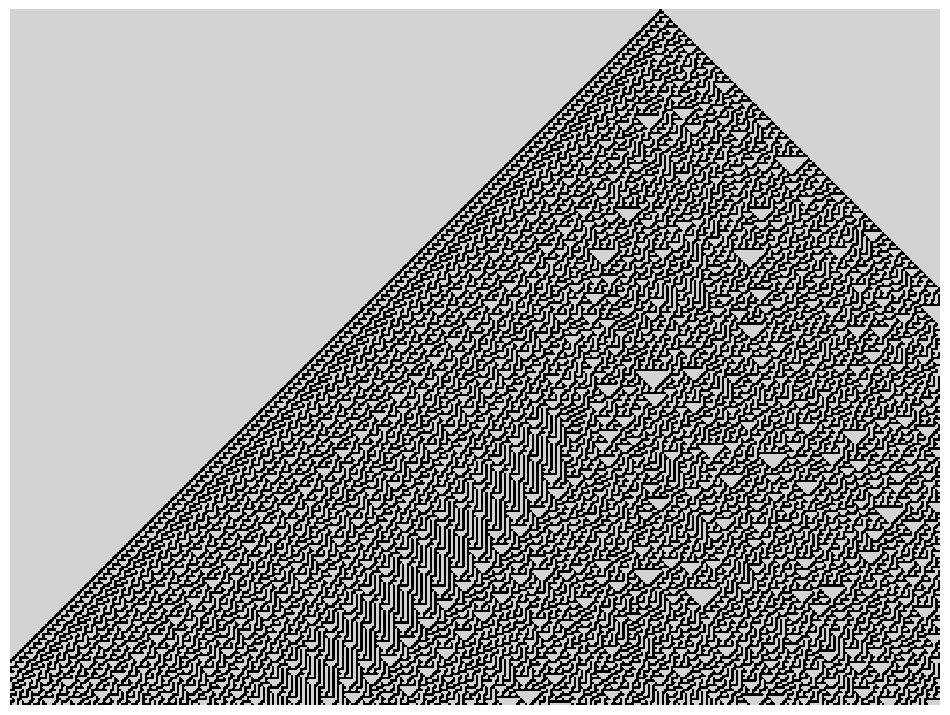

In [7]:
grid = generate_automaton(rule_functions['Rule 30'])
plot_automaton_grid(get_grid_subset(grid, start_step=0, width=400, steps=300, middle_index=420), outline=True)

In [8]:
# grid = generate_automaton(400, 400, rule_30)
# plot_automaton_grid(grid, outline=True)

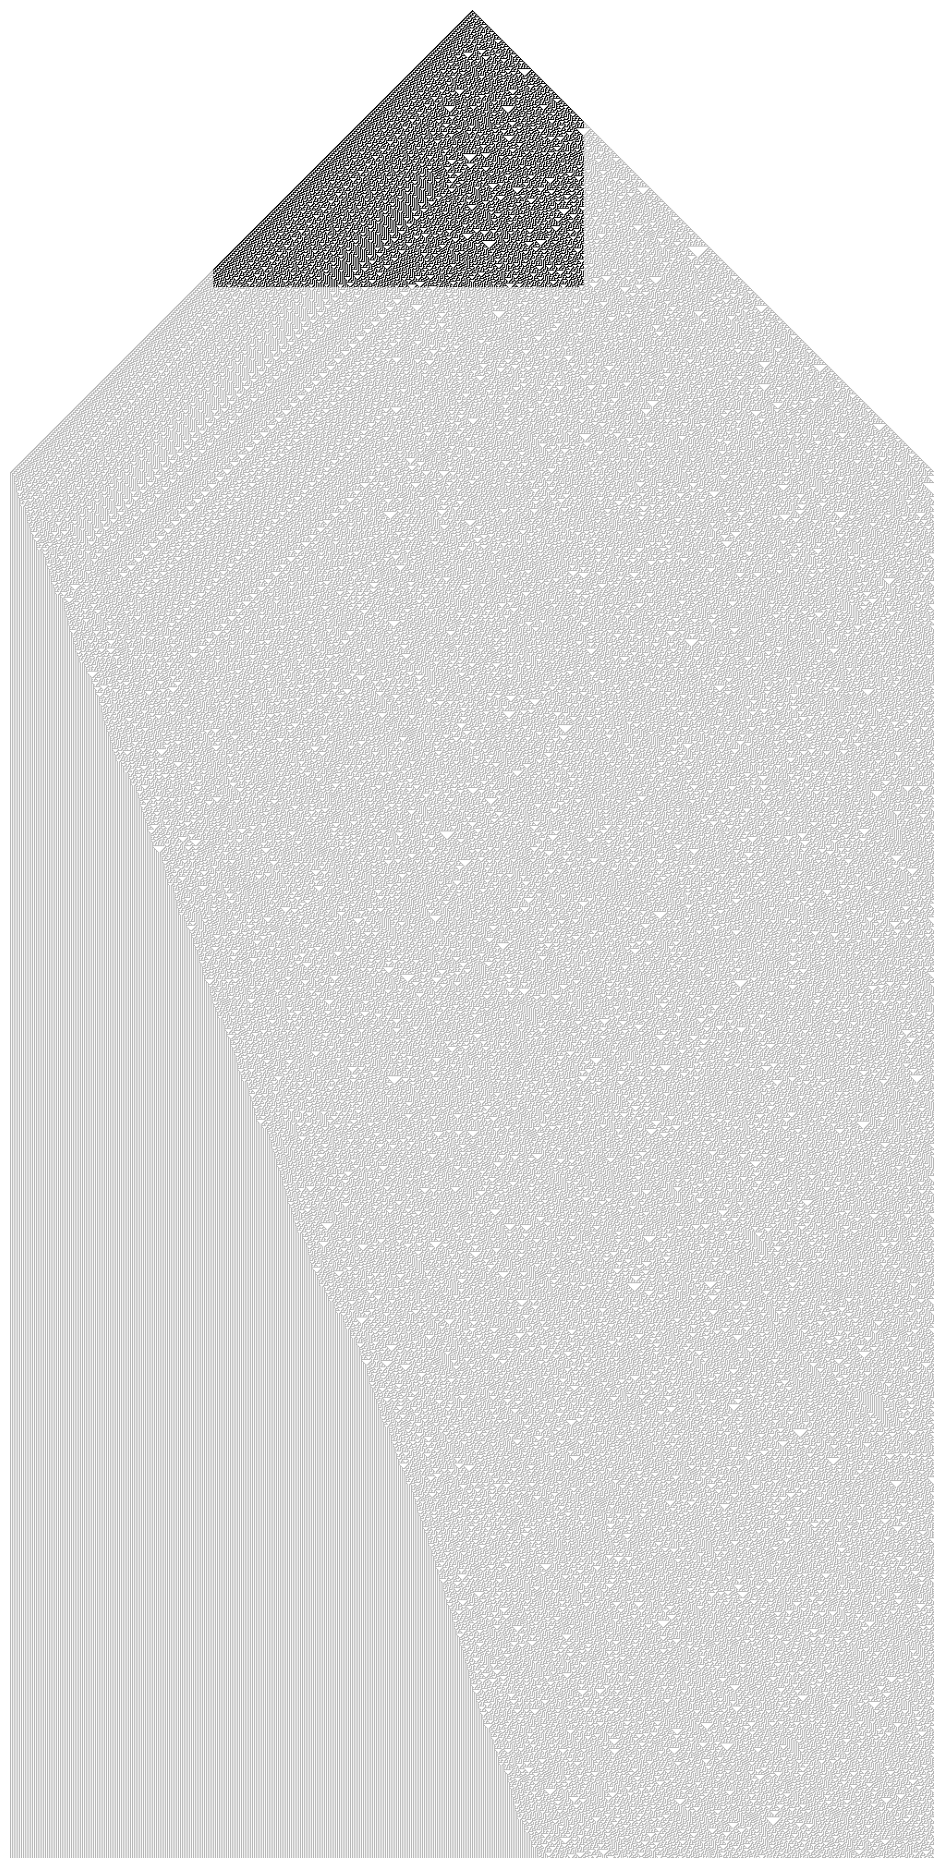

In [9]:
# Generate a sample grid using Rule 30 for demonstration
highlight_grid_subset(grid, start_step=0, width=400, steps=300, middle_index=420)
# highlight_grid_subset(grid, start_step=500, width=400, steps=300, middle_index=1150, raise_exceptions=True)

In [10]:
@interact(s=(0,len(grid)-1,1))
def foop(s=0):
    plot_automaton_step(grid, s, outline=True)
    return

interactive(children=(IntSlider(value=0, description='s', max=1999), Output()), _dom_classes=('widget-interact…

In [11]:
# grid = generate_automaton(400, 200, rule_110)
# plot_automaton_grid(grid, outline=True, image_width=6)
# grid.shape[0] // 2

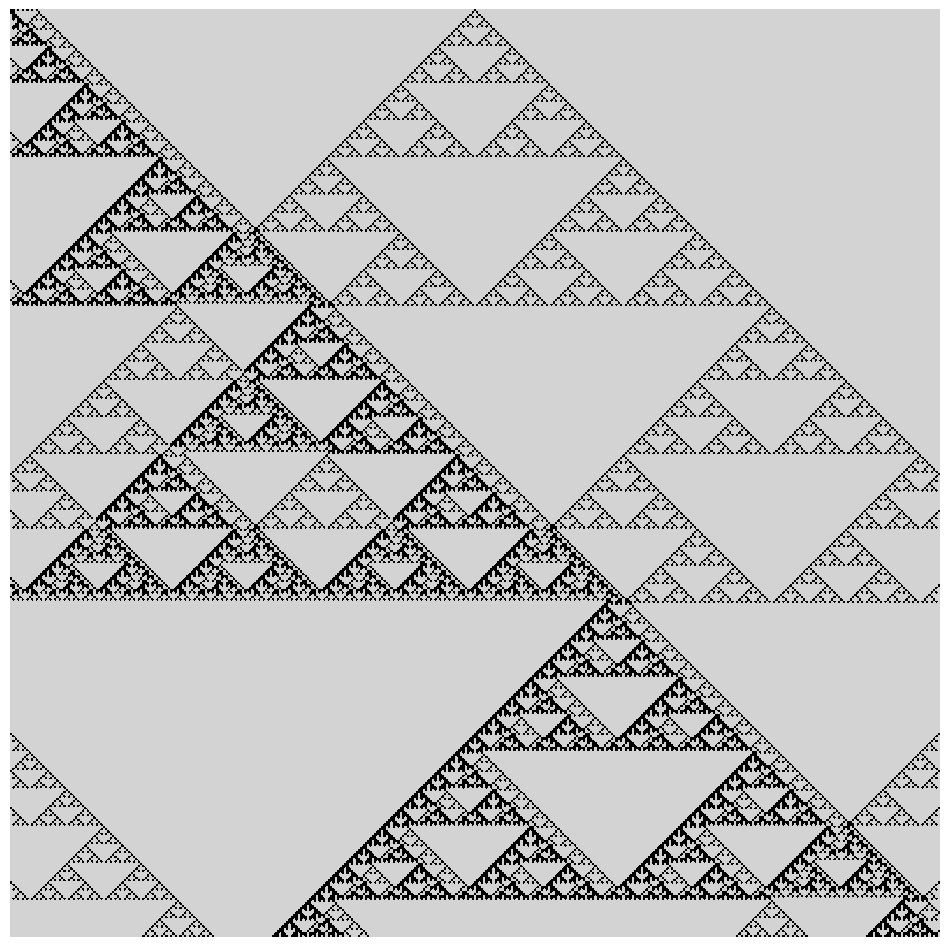

In [12]:
grid = generate_automaton(rule_functions['Rule 90'], initial_conditions=([300, 301, 303, 305, 307, 309, 311, 500]))
#get_grid_subset(grid, start_step=0, width=20, steps=2)
plot_automaton_grid(get_grid_subset(grid, start_step=0, width=400, steps=400), outline=True)

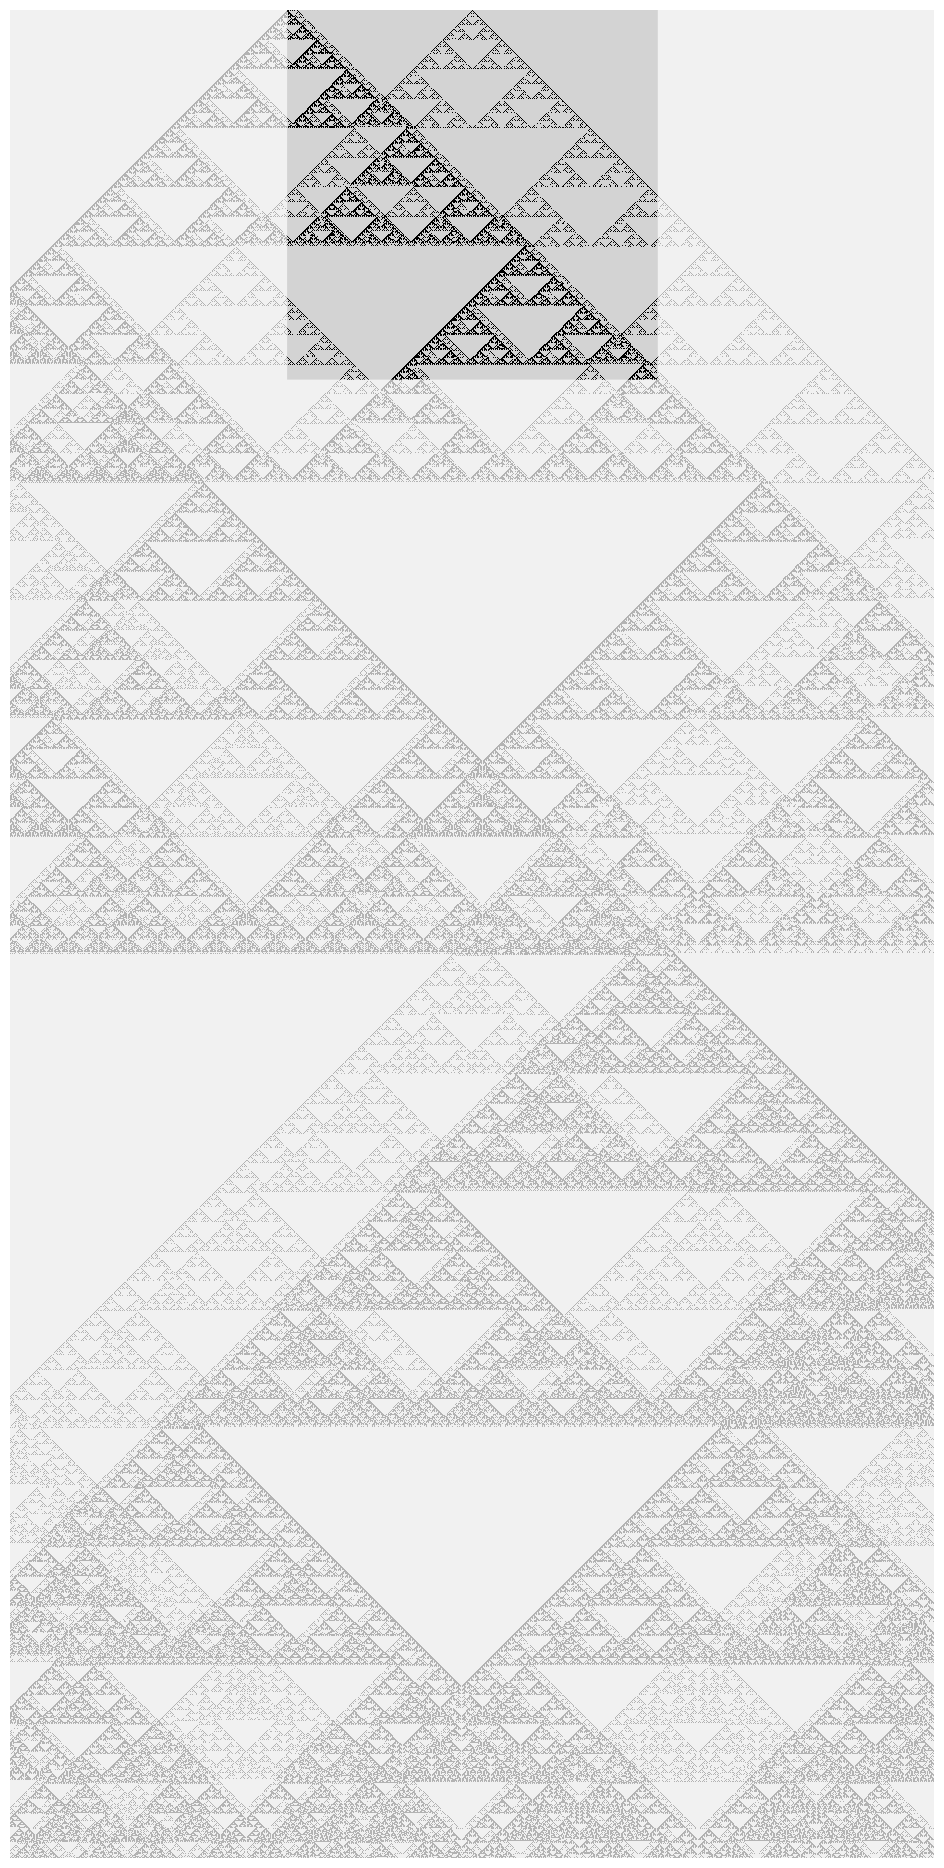

In [13]:
highlight_grid_subset(grid, start_step=0, width=400, steps=400, outline=True)

In [15]:
@interact(s=(0,len(grid)-1,1))
def foop(s=0):
    plot_automaton_step(grid, s, outline=True)
    return

interactive(children=(IntSlider(value=0, description='s', max=1999), Output()), _dom_classes=('widget-interact…